In [1]:
%matplotlib notebook


import pickle as pkl
from graph_tool import Graph, load_graph
from glob import glob
from utils import earliest_obs_node
from gt_utils import edges_to_directed_tree, get_roots
from feasibility import is_arborescence
from tqdm import tqdm


In [2]:
from gt_utils import edges2graph
g = load_graph('data/grid-64/graph.gt')
p = 'outputs/paper_experiment/grid-64/si/no-order/qs/0.2/50.pkl'
infection_times, source, obs_nodes, true_edges, pred_edges = pkl.load(open(p, 'rb'))
t = edges2graph(g, pred_edges)

assert is_arborescence(t)    

In [3]:
from graph_tool.all import GraphView, min_spanning_tree
from steiner_tree import build_closure, get_steiner_tree

gc, eweight, r2pred = build_closure(g, obs_nodes)

tree_map = min_spanning_tree(gc, eweight, root=None)
gc_tree = GraphView(gc, directed=False, efilt=tree_map)

In [4]:
root = earliest_obs_node(obs_nodes, infection_times)
t = get_steiner_tree(g, root, obs_nodes)

<IPython.core.display.Javascript object>


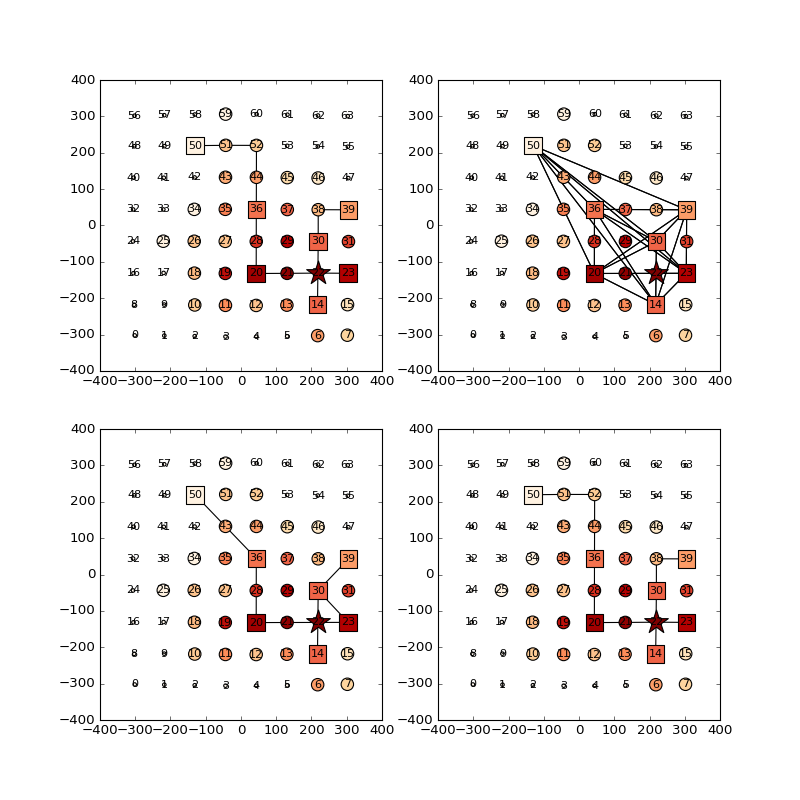

In [6]:
from matplotlib import pyplot as plt

from plot_utils import plot_snapshot
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from utils import build_minimum_tree
from gt_utils import extract_edges

gnx = nx.read_graphml('data/grid/2-6/graph.graphml')
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
pos = graphviz_layout(gnx, root=0)


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(t))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(gc))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(gc_tree))
if True:  
    correct_t = build_minimum_tree(g, root, obs_nodes, extract_edges(t))
    plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
                  ax=ax[1, 1],
                  edges=extract_edges(correct_t))